In [1]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt

from analysis.models.vr import RatCAVESession
from analysis.plots.placecells.F02_AB_cells import all_AB_cells, shift_plot, single_unit_plot
from analysis.plots.trajectory import arena_vs_animal_positions

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Overview

In [3]:
# 00908
sessions = [
    "2019-07-24_20-31-26"   # a few place cells, little efects
]

# 00910
sessions = [
    "2019-08-05_14-08-23",  # poor session
    "2019-08-06_11-24-47",  # poor session
    "2019-08-06_16-58-32",  # session with broken periods
    "2019-08-07_11-01-52",  # a few place cells, little efects
    "2019-08-07_16-16-13",  # a few place cells, little efects
    "2019-08-08_10-13-38",  # putative effects
    "2019-08-08_18-42-52",  # putative reward cell 7-5, 
    "2019-08-09_13-36-37",  # putative reward cell and behavior, 7-2
    "2019-08-09_16-35-22",  # putative reward cell and behavior, 7-2
    "2019-08-12_17-16-34",  # broken session (run + sleep) need to FIX
    "2019-08-13_11-09-22",  # 6-2, 6-6, 7-4, 7-5, 7-7 -> goes to TAC
    "2019-08-13_17-31-03",  # a few place cells, little efects
    "2019-08-15_12-33-23"   # a few place cells, little efects
]

# 003282
sessions = [
    "2019-11-27_22-17-07"
]

source = '/home/andrey/storage2/andrey/data/processed'
animal = '003282'
session_id = "2019-11-27_22-17-07"

sessionpath = os.path.join(source, animal, session_id)

session = RatCAVESession(sessionpath, alpha=4.3)
running_idxs = session.get_running_indexes(threshold=0.15)[0]

if not os.path.exists(os.path.join(sessionpath, 'analysis')):
    os.makedirs(os.path.join(sessionpath, 'analysis'))
    
if not os.path.exists(os.path.join(sessionpath, 'units')):
    os.makedirs(os.path.join(sessionpath, 'units'))

In [8]:
session.tetrode_unit_map

{1: [],
 2: [],
 3: [],
 4: [2, 3, 4, 5],
 5: [2],
 6: [],
 7: [2, 3, 4, 5, 6, 7, 8, 9],
 8: []}

# Preparing data

In [9]:
t_start = session.trajectory[0][0]
t_shift = t_start + 600

# cut the bad data outside arena
x_lim = [-0.55, 0.20]
y_lim = [-0.75, 0.90]

traj = session.trajectory
session.trajectory = traj[(traj[:, 1] > x_lim[0]) & (traj[:, 1] < x_lim[1]) & (traj[:, 2] > y_lim[0]) & (traj[:, 2] < y_lim[1])]

# Arena positions before and after the VR shift
traj = session.arena_trajectory
ar_traj_0 = np.array(traj[(traj[:, 0] < t_shift)])
ar_traj_1 = np.array(traj[(traj[:, 0] > t_shift)])

# Animal positions before and after the VR shift
traj = session.trajectory

an_traj_0_idxs = np.where((traj[:, 0] < t_shift))[0]
an_traj_1_idxs = np.where((traj[:, 0] > t_shift))[0]

an_traj_0_idxs = np.array([x for x in an_traj_0_idxs if x in running_idxs])
an_traj_1_idxs = np.array([x for x in an_traj_1_idxs if x in running_idxs])

# an_traj_0 = np.array(traj[(traj[:, 0] < t_shift)])
# an_traj_1 = np.array(traj[(traj[:, 0] > t_shift)])

an_traj_0 = traj[an_traj_0_idxs]
an_traj_1 = traj[an_traj_1_idxs]

# Arena and animal Z positions

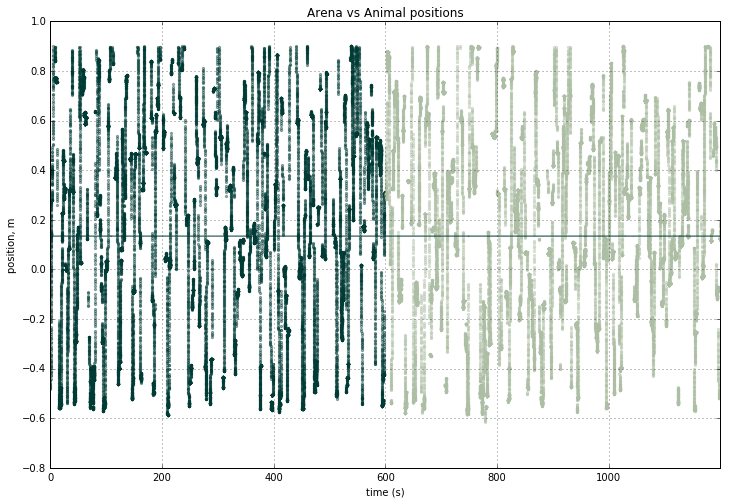

In [10]:
fig = arena_vs_animal_positions(session.arena_trajectory, an_traj_0, an_traj_1)

# All cells firing maps

Processing unit group 7..

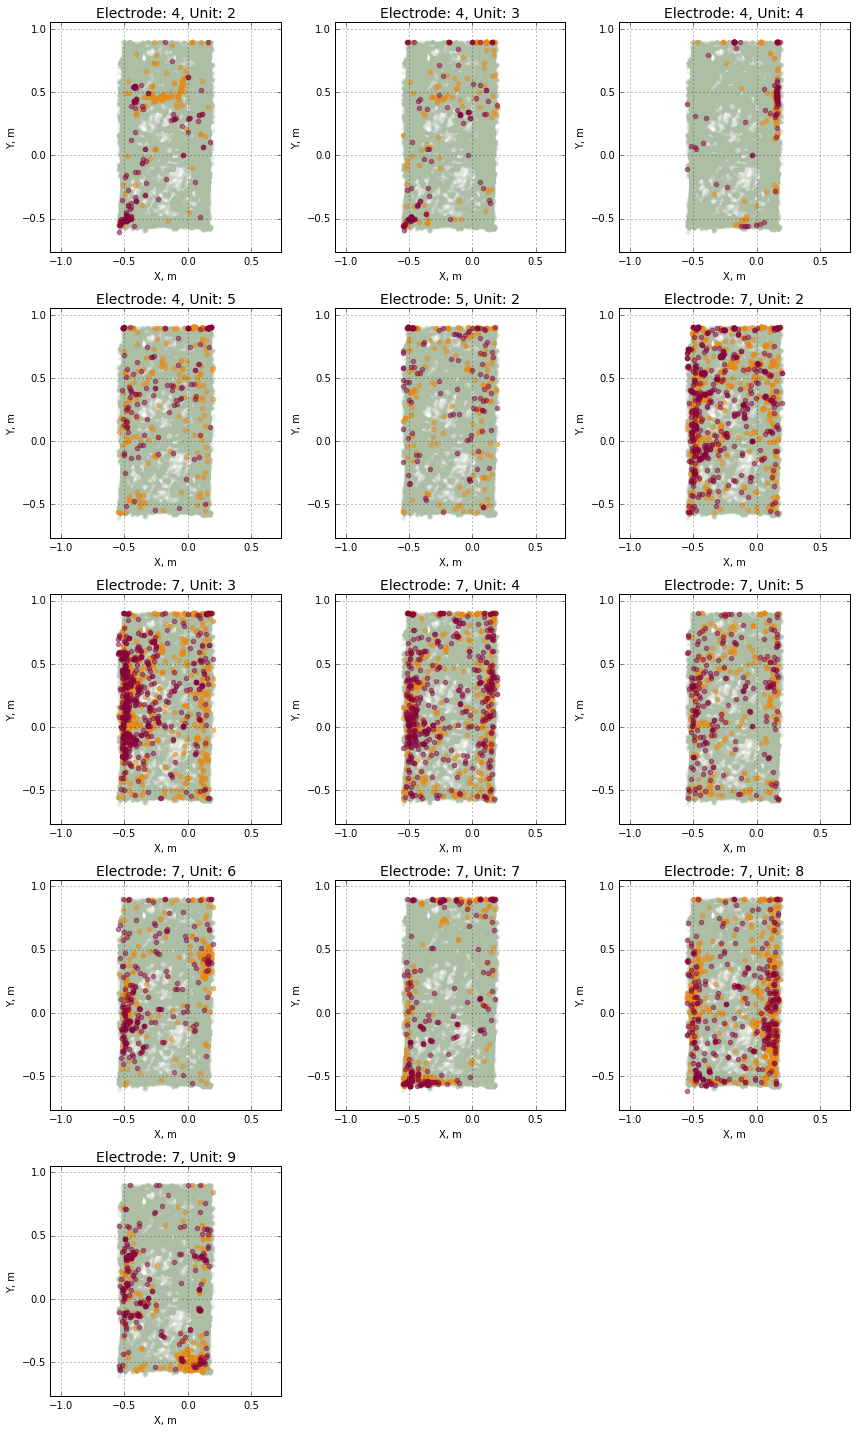

In [11]:
fig = all_AB_cells(session, an_traj_0_idxs, an_traj_1_idxs)

filename = "all_units.png"
fig.savefig(os.path.join(os.path.join(sessionpath, 'analysis'), filename))

# Single Unit firing map

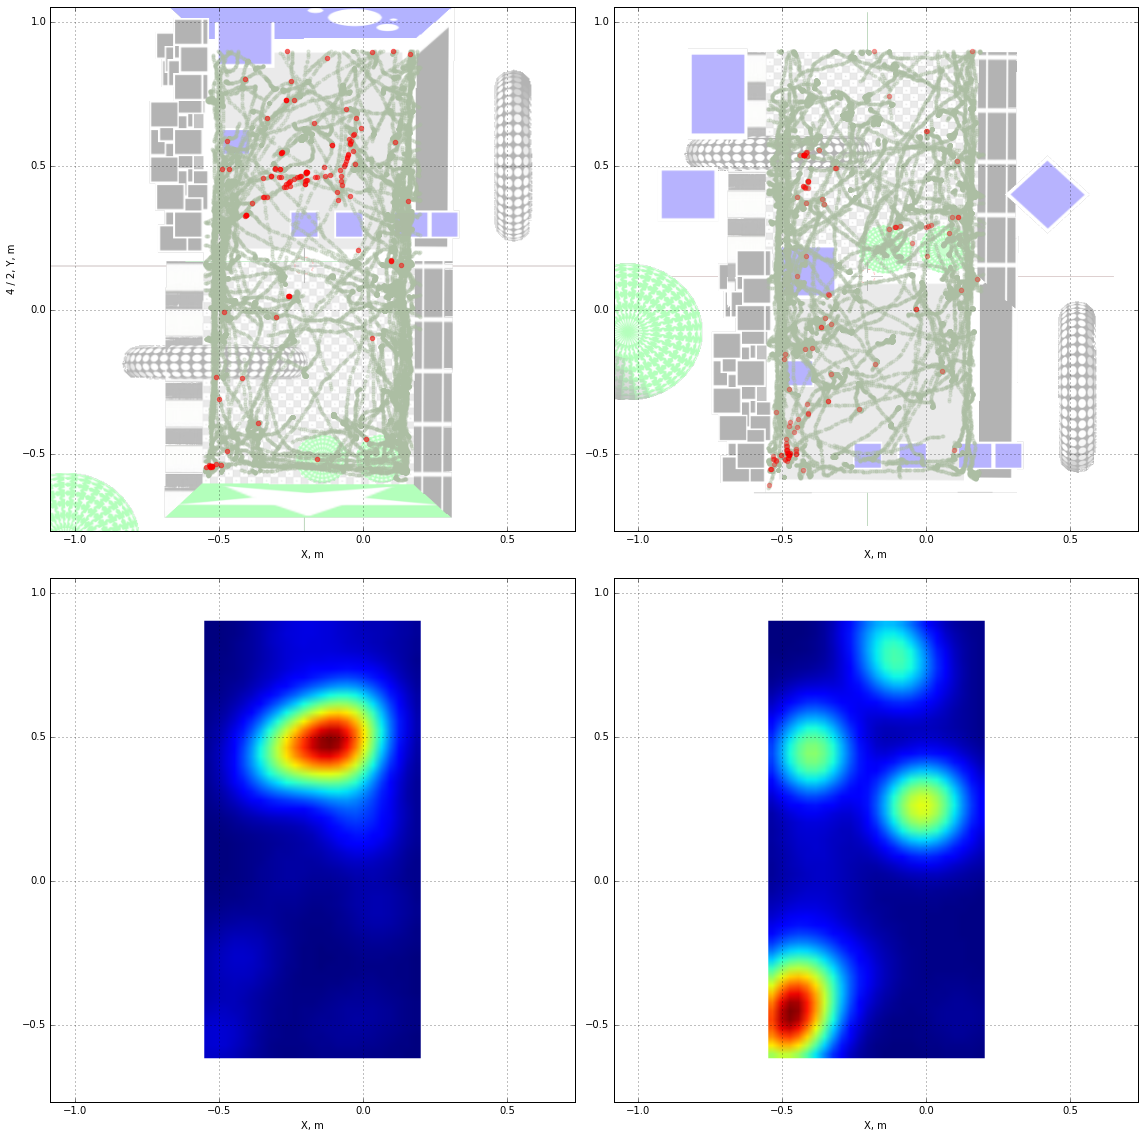

In [14]:
import matplotlib.pyplot as plt
from analysis.plots.placecells.utils import get_figure_size, get_extent
from analysis.models.analytics import place_field_2D


def downsample(traj, sampling_rate=50):
    pos_at_f = [traj[0]]
    for pos in traj:
        if pos[0] - pos_at_f[-1][0] > (1 / float(sampling_rate)):
            pos_at_f.append(pos)

    return np.array(pos_at_f)
    
ttd = 4
unit = 2
sampling_rate = 50

# positions where unit was firing (trajectory slices)
unit_fire_0 = session.get_positions_for_unit2(ttd, unit, an_traj_0_idxs)
unit_fire_1 = session.get_positions_for_unit2(ttd, unit, an_traj_1_idxs)

# remove dumpded spiking periods (when position recording freezed etc.)
unit_fire_0 = unit_fire_0[:-1][np.diff(unit_fire_0[:,0]) > 0]
unit_fire_1 = unit_fire_1[:-1][np.diff(unit_fire_1[:,0]) > 0]

pos_at_f0 = downsample(an_traj_0)
pos_at_f1 = downsample(an_traj_1)

limits = get_figure_size(session.trajectory[:, 1:3])
extent = np.array(get_extent(session.trajectory[:, 1:3]))
img_AB = plt.imread(os.path.join(session.path, "AB.png"))
img_BA = plt.imread(os.path.join(session.path, "BA.png"))

fig = plt.figure(figsize=(16, 16))

# firing AB
ax = fig.add_subplot(2, 2, 1)
ax.grid(True)
ax.set_xlabel('X, m')
ax.set_ylabel('%s / %s, Y, m' % (ttd, unit))
ax.set_xlim(limits[0], limits[1])
ax.set_ylim(limits[2], limits[3])
ax.scatter(an_traj_0[:, 1], an_traj_0[:, 2], s=10, alpha=0.3, color='#acbea3')
ax.scatter(unit_fire_0[:, 1], unit_fire_0[:, 2], alpha=0.5, color='r')
ax.imshow(img_AB, extent=[-1.4, 0.8, -1.6, 1.85], alpha=0.3)


# firing BA
ax = fig.add_subplot(2, 2, 2)
ax.grid(True)
ax.set_xlabel('X, m')
ax.set_xlim(limits[0], limits[1])
ax.set_ylim(limits[2], limits[3])
ax.scatter(an_traj_1[:, 1], an_traj_1[:, 2], s=10, alpha=0.3, color='#acbea3')

lg = int(len(unit_fire_1) / 2)
ax.scatter(unit_fire_1[:lg, 1], unit_fire_1[:lg, 2], alpha=0.3, color='r')
ax.scatter(unit_fire_1[lg:, 1], unit_fire_1[lg:, 2], alpha=0.3, color='r')

ax.imshow(img_BA, extent=[-1.35, 0.65, -0.75, 1.03], alpha=0.3)


# place field AB
omap0, smap0, fmap0, s_firing_map_0 = place_field_2D(pos_at_f0[:, 1:3], unit_fire_0[:, 1:3], sampling_rate, 0.03)

ax = fig.add_subplot(2, 2, 3)
ax.grid(True)
ax.set_xlabel('X, m')
ax.set_xlim(limits[0], limits[1])
ax.set_ylim(limits[2], limits[3])
ax.imshow(s_firing_map_0.T, cmap='jet', origin='lower', extent=extent)


# place field BA
omap1, smap1, fmap1, s_firing_map_1 = place_field_2D(pos_at_f1[:, 1:3], unit_fire_1[:, 1:3], sampling_rate, 0.03)

ax = fig.add_subplot(2, 2, 4)
ax.grid(True)
ax.set_xlabel('X, m')
ax.set_xlim(limits[0], limits[1])
ax.set_ylim(limits[2], limits[3])
ax.imshow(s_firing_map_1.T, cmap='jet', origin='lower', extent=extent)

fig.tight_layout()


filename = "firing_ttd_%s_unit_%s.png" % (ttd, unit)
fig.savefig(os.path.join(os.path.join(sessionpath, 'analysis'), filename))

# Some playground below

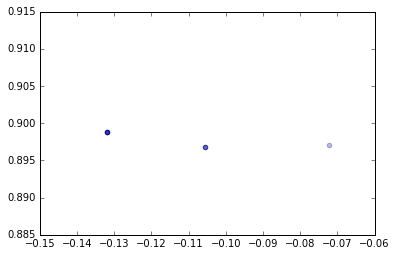

In [70]:
fire = unit_fire_1[(unit_fire_1[:, 2] > 0.89) & (unit_fire_1[:, 1] > -0.2) & (unit_fire_1[:, 1] < 0)]

plt.scatter(fire[:, 1], fire[:, 2], alpha=0.1)

In [80]:
np.diff(fire[:,0] - session.trajectory[0][0])

array([   0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
         59.79999995,    0.        ,    0.        ,  118.44499993,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ])

In [101]:
fire[-1][0]

1565687920.53

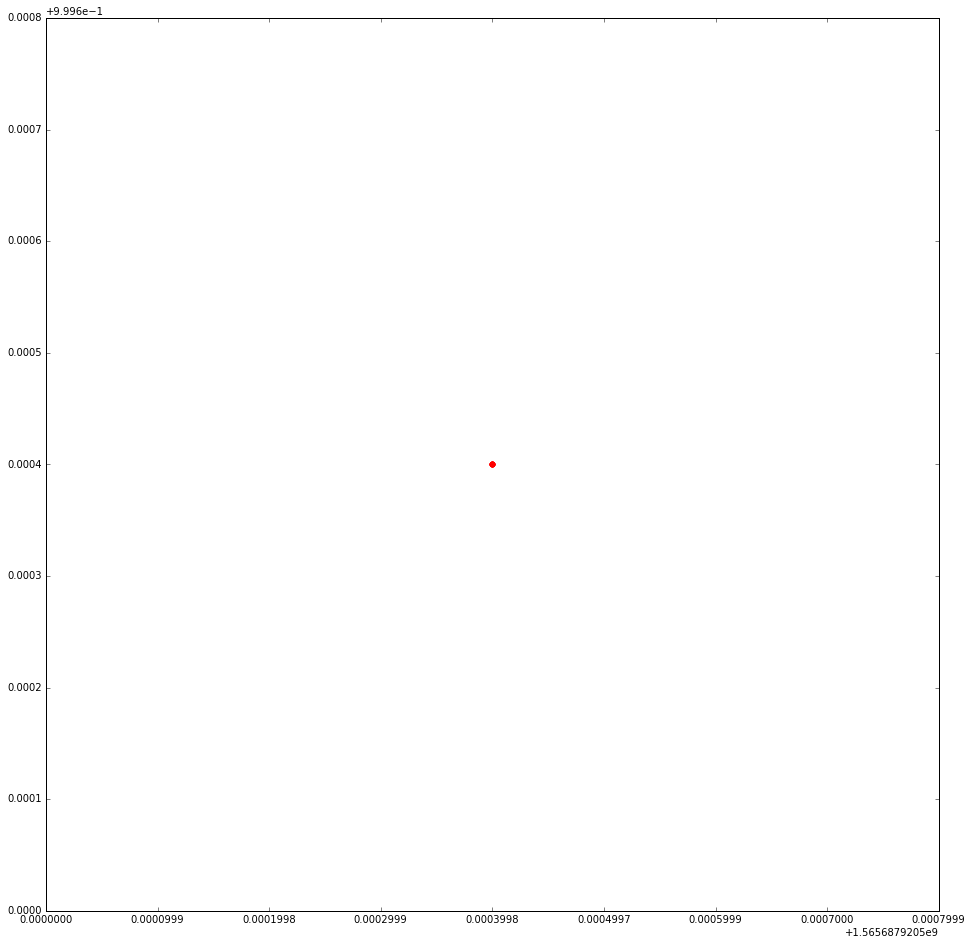

In [171]:
f1 = fire[(fire[:,0] > 1565687919.53)]
vel = session.velocity[(session.velocity[:,0] > 1565687915.53) & (session.velocity[:,0] < 1565687921.53)]
vel_s = session.smoothed_velocity()[(session.smoothed_velocity()[:,0] > 1565687915.53) & (session.smoothed_velocity()[:,0] < 1565687921.53)]


fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111)

ax.plot(vel[:,0], vel[:,1])
ax.scatter(vel_s[:,0], vel_s[:,1], color='g')
ax.scatter(f1[:,0], np.ones(len(f1)), color='r')

In [129]:
len(unit_fire_0[:-1][np.diff(unit_fire_0[:,0]) > 0])

335